# Timeseries
Our goal here is to identify the following features:
* *trend* or consistent non-periodic directional movement
* *seasonal* (periodic) variation
* residual stochastic variation (*noise*)

*Trend* and *seasonal* make a base for forcasting; *noise* adjusts our prediction confidence intervals.

In [1]:
import os, re
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from IPython.core.display import display, HTML
register_matplotlib_converters()
%matplotlib inline

In [2]:
with open('header','r') as source:
    FEATURES = source.read().strip().split(',')
    
YEARS = np.arange(2010, 2020)

In [3]:
# memoization table
lookup = dict()
# get feature value given the index
def get_name(f,i):
    if int(i) == 0:
        return 'Other'
    if not f in lookup:
        try: # check if we have local index (updated categorization)
            index = pd.read_csv('./data/local-{}'.format(FEATURES.index(f)), header = None)[0]
        except FileNotFoundError:
            index = pd.read_csv('./data/index-{}.csv'.format(FEATURES.index(f)))['value']
        lookup[f] = index.tolist()
    return lookup[f][int(i) - 1]

In this notebook we are going to explore the Agency / City trends.

In [4]:
FEATURES.index('Agency'), FEATURES.index('City') 

(3, 16)

In [5]:
!head -n5 ./data/index-16.csv

value,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
BROOKLYN,604021,590496,535163,540828,631071,678905,702602,755846,848926,743305,6631163
NEW YORK,365642,351366,329152,356915,412335,457738,503476,469055,498035,450914,4194628
BRONX,380242,361459,322314,325332,378414,399300,425238,435441,466654,417778,3912172
STATEN ISL,100545,99986,86908,85349,102751,108311,109933,129089,152943,125941,1101756


Let us explore the timeseries for the top-count agencies in the top-count cities (Brooklyn, NY, Bronx):
1. HPD (hot water, heating)
2. NYPD (illegal parking, banging and pounding)
3. DOT (street light out, pothole)
4. DSNY (bulky item, blocked drwy)
5. DEP (water system, sewer)
6. DOB (building, plumbing)
7. DPR (tree fallen down)
8. DOHMH (rat sighting)

Note: agency "dominant content" comes from our [topic-modeling notebook](Taxonomy.ipynb).

In [6]:
# feature + filter
query = [('City', list('123')), ('Agency', list('12345678')), ('Created Date', None)]

In [7]:
# query data for the set of features with filters aggregated by date (should come last in the list)
def get_series(query):
    columns = [name for name,cond in query]
    ts = pd.DataFrame([], columns = columns + [0])
    for y in YEARS:
        data = pd.read_csv('./data/{}.csv'.format(y), dtype = str).set_index('Unique Key')[columns]
        for name,cond in query:
            if not cond is None:
                data = data.loc[data[name].isin(cond)]
        data = data.groupby(columns).size().reset_index()
        ts = ts.append(data.copy())
    # the last term is date
    ts[columns[-1]] = pd.to_datetime(ts[columns[-1]], infer_datetime_format = True)
    ts = ts.set_index(columns[-1]).dropna()
    ts.columns = columns[:-1] + ['Total']
    return ts

In [8]:
# get the timeseries data
TS = get_series(query)

In [9]:
# plot the trends with aggregation "d" (default "daily")
def show_trends(ts, d = 'D'):
    D = {'D':'Daily', 'W':'Weekly', 'M':'Monthly', 'Y':'Yearly'}
    
    fig, ax = plt.subplots(len(query[1][1]), 1, figsize = (12, 3 * len(query[1][1])))
    # selected agencies
    for i,a in enumerate(query[1][1]):
        # selected cities
        for j,c in enumerate(query[0][1]):
            S = ts[(ts['Agency'] == a) & (ts['City'] == c)]['Total'].resample(d).sum()
            ax[i].plot(S, alpha = .5, label = get_name('City', c))
            ax[i].set_title('{} {} domain incidents'.format(D[d], get_name('Agency', a)))
            ax[i].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc:'{:,}'.format(int(x))))
            ax[i].legend()
            
    plt.tight_layout()
    plt.show()

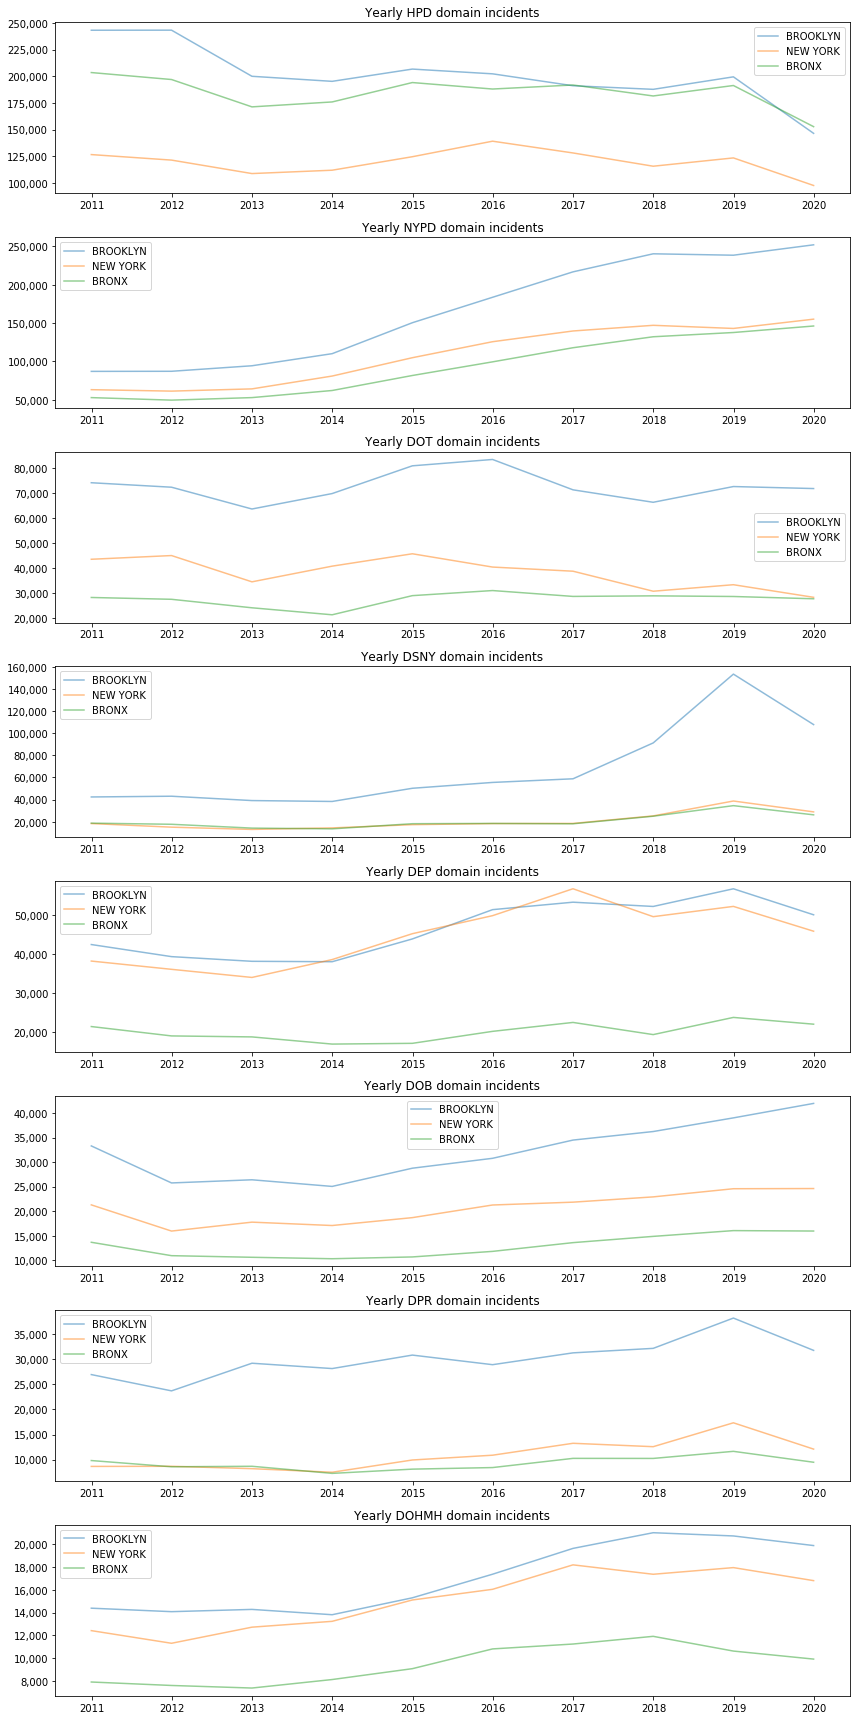

In [10]:
# let's see yearly trends
show_trends(TS, d = 'Y')

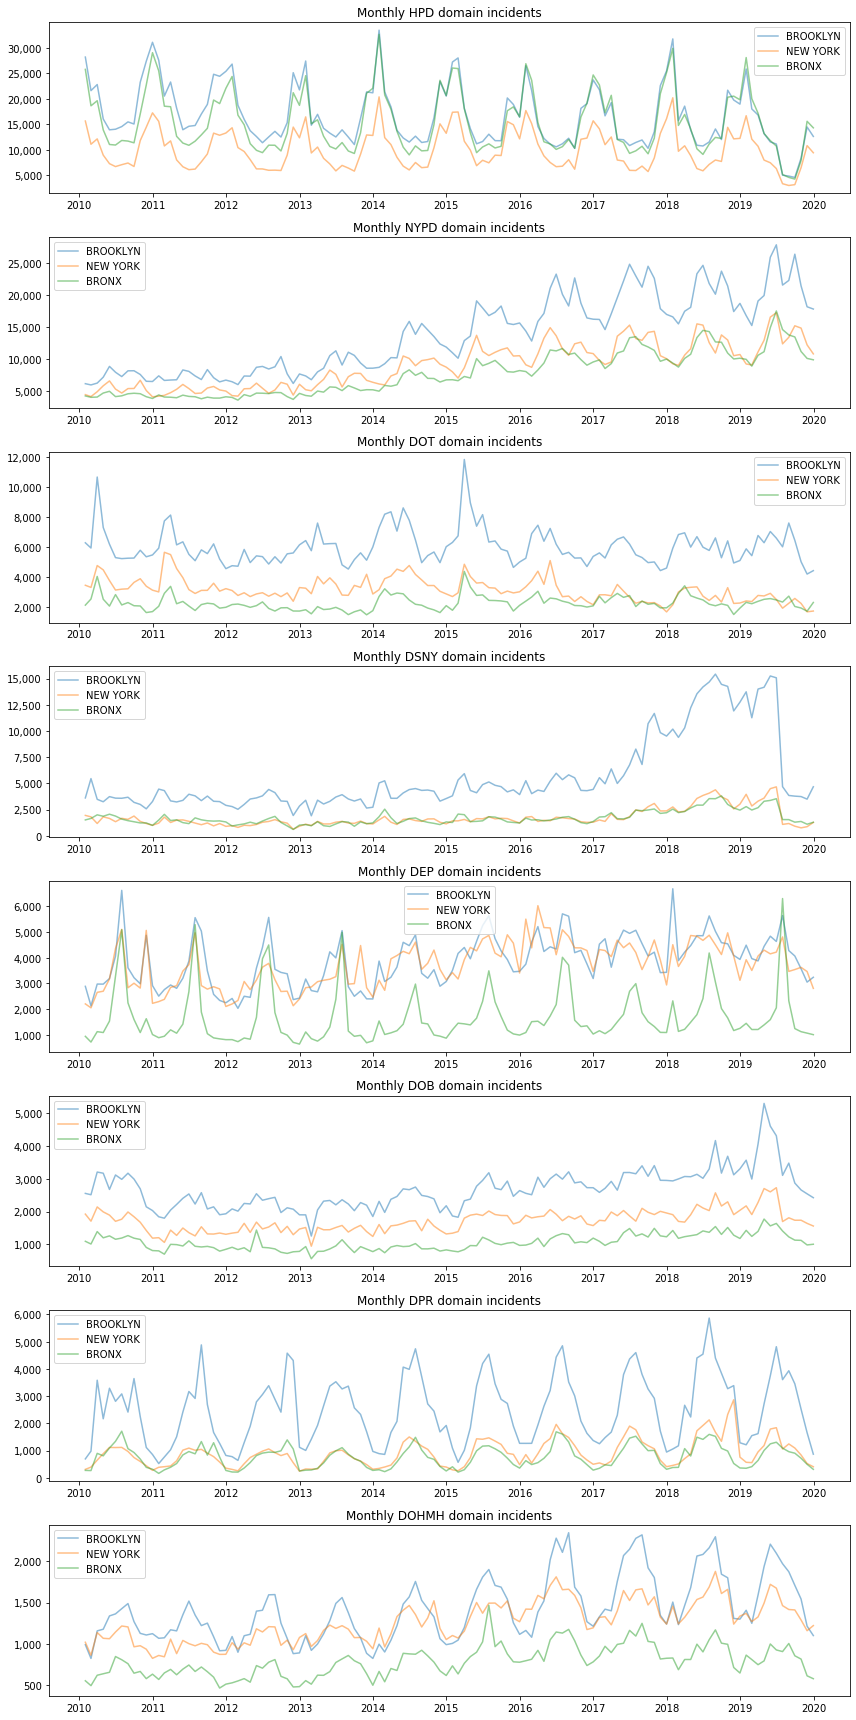

In [11]:
# monthly
show_trends(TS, d = 'M')

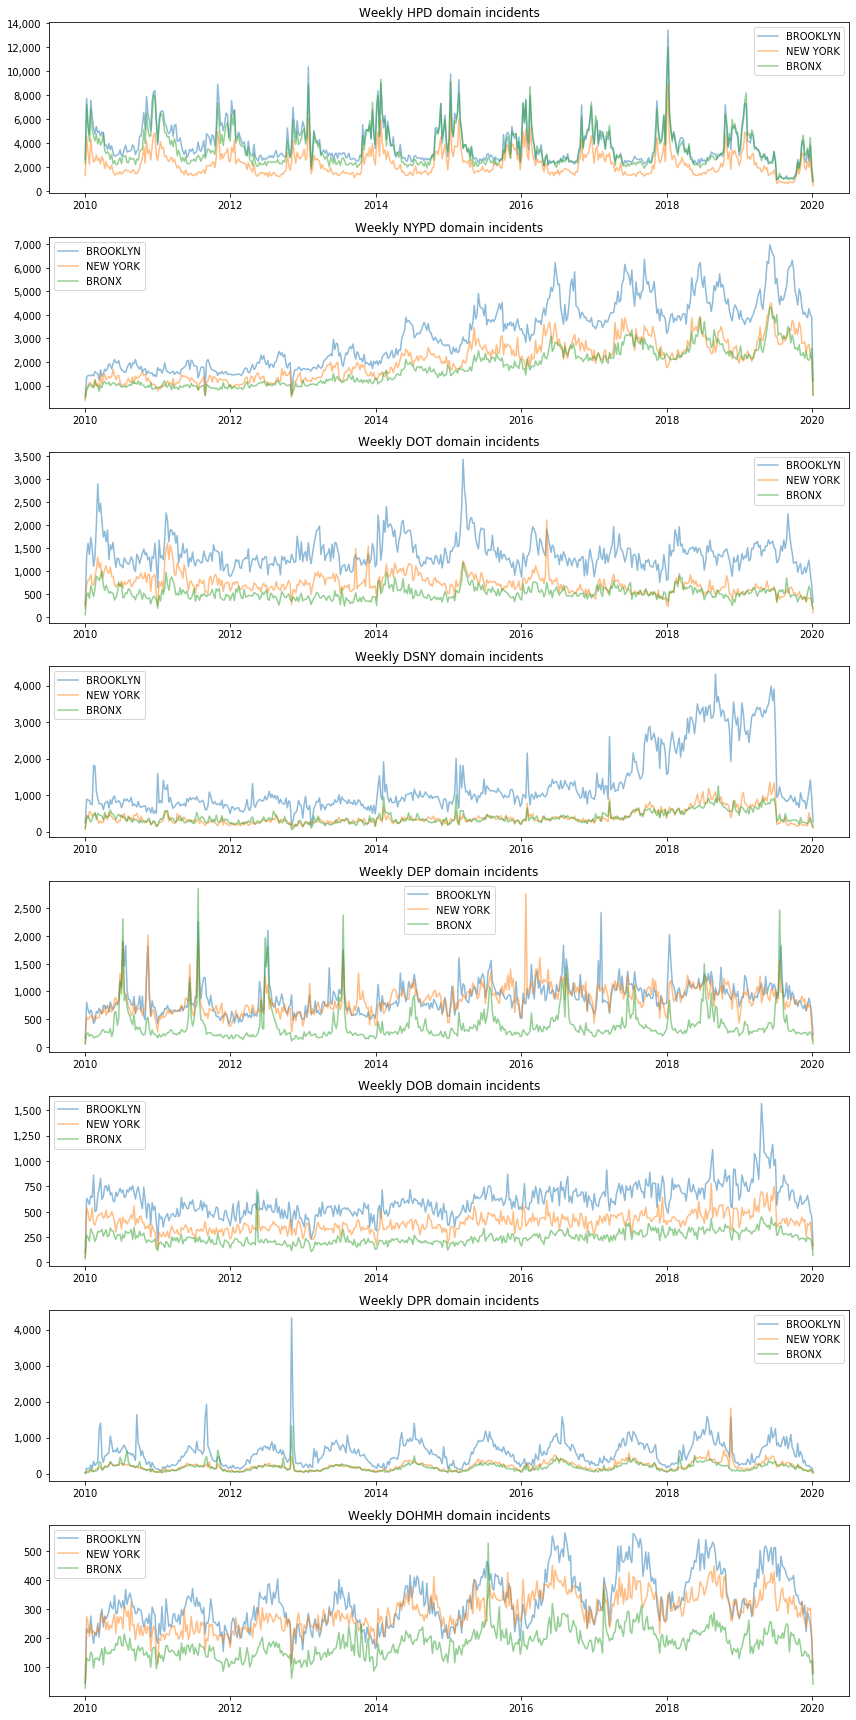

In [12]:
# weekly
show_trends(TS, d = 'W')

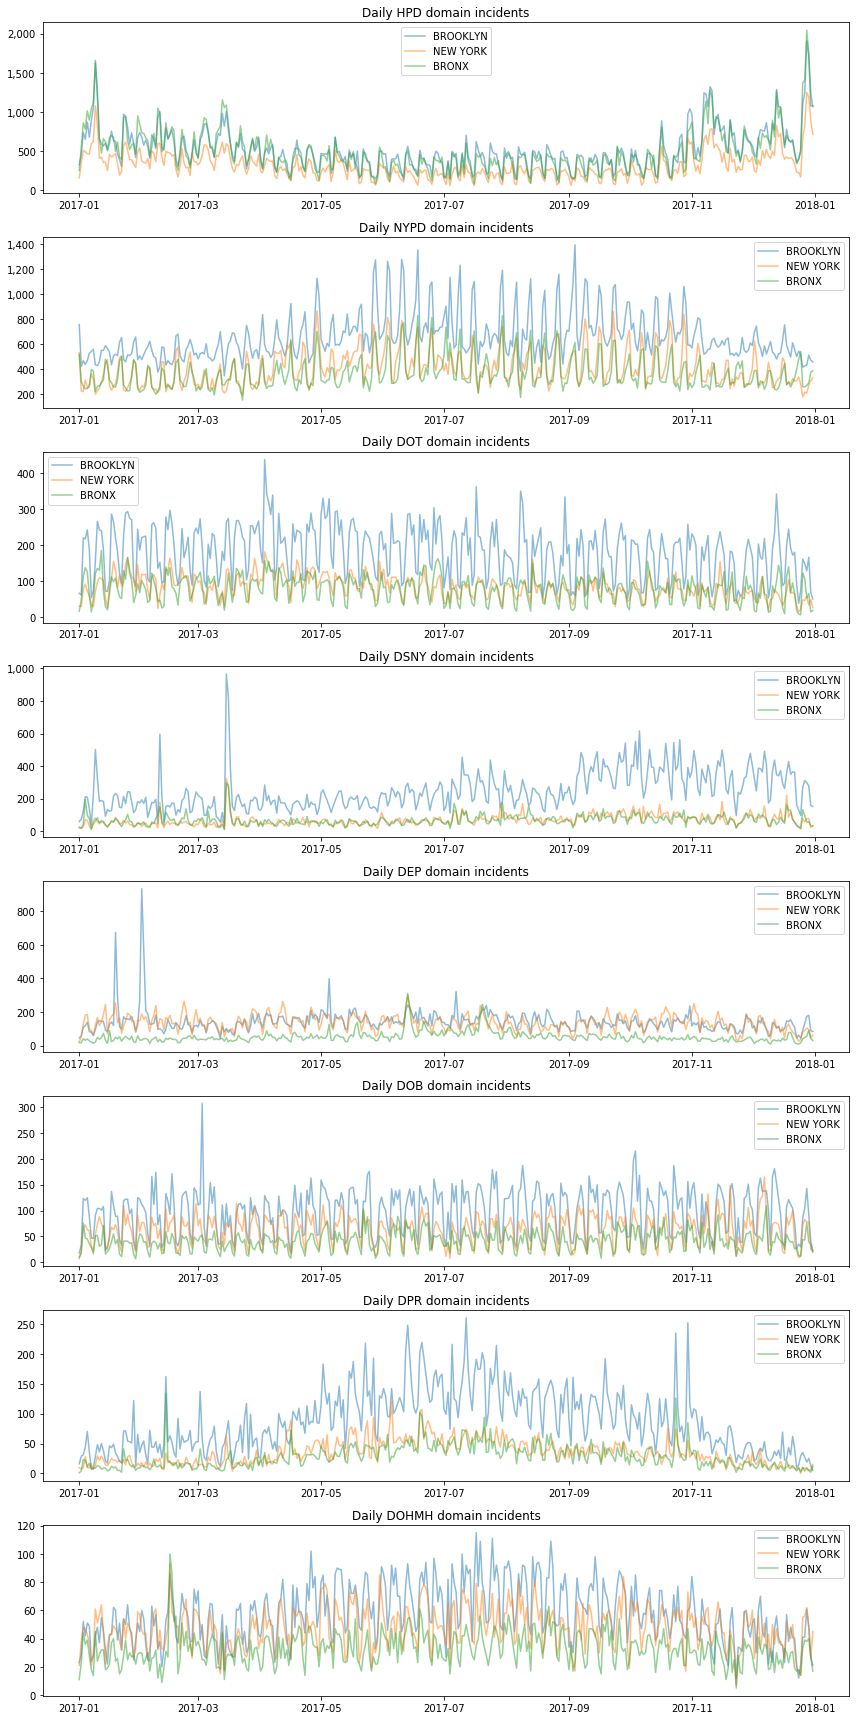

In [13]:
# 2017 daily
show_trends(TS[TS.index.year == 2017])

Observation: there is a distinct seasonal pattern where we would expect it to be and a distict global trend in some.